https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [93]:
!pip install yfinance pmdarima

In [45]:
import yfinance
from datetime import datetime, date, timedelta
from statsmodels.tsa.stattools import adfuller
from numpy import log

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
current_date = datetime.now().strftime('%Y-%m-%d')

In [6]:
max_timestamp = date.today()-timedelta(days=365*2)

In [55]:
prices_data_df = yfinance.download('BTC-USD', start=max_timestamp, end=current_date)

[*********************100%***********************]  1 of 1 completed


In [56]:
prices_data_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-12-24  7354.393066  7535.716797  7269.528809  7322.532227  7322.532227   
2019-12-25  7325.755859  7357.020020  7220.991211  7275.155762  7275.155762   
2019-12-26  7274.799316  7388.302734  7200.386719  7238.966797  7238.966797   
2019-12-27  7238.141113  7363.529297  7189.934082  7290.088379  7290.088379   
2019-12-28  7289.031250  7399.041016  7286.905273  7317.990234  7317.990234   

                 Volume  
Date                     
2019-12-24  22991622105  
2019-12-25  21559505149  
2019-12-26  22787010034  
2019-12-27  22777360996  
2019-12-28  21365673026

## Check if the series is stationary

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [63]:
prices_data_for_arima_df = prices_data_df.reset_index()[['Date', 'Close']]

In [64]:
result = adfuller(prices_data_for_arima_df['Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.932860
p-value: 0.776959


Since P-value is greater than the significance level **0.746441 > 0.05**, let’s difference the series and see how the autocorrelation plot looks like.

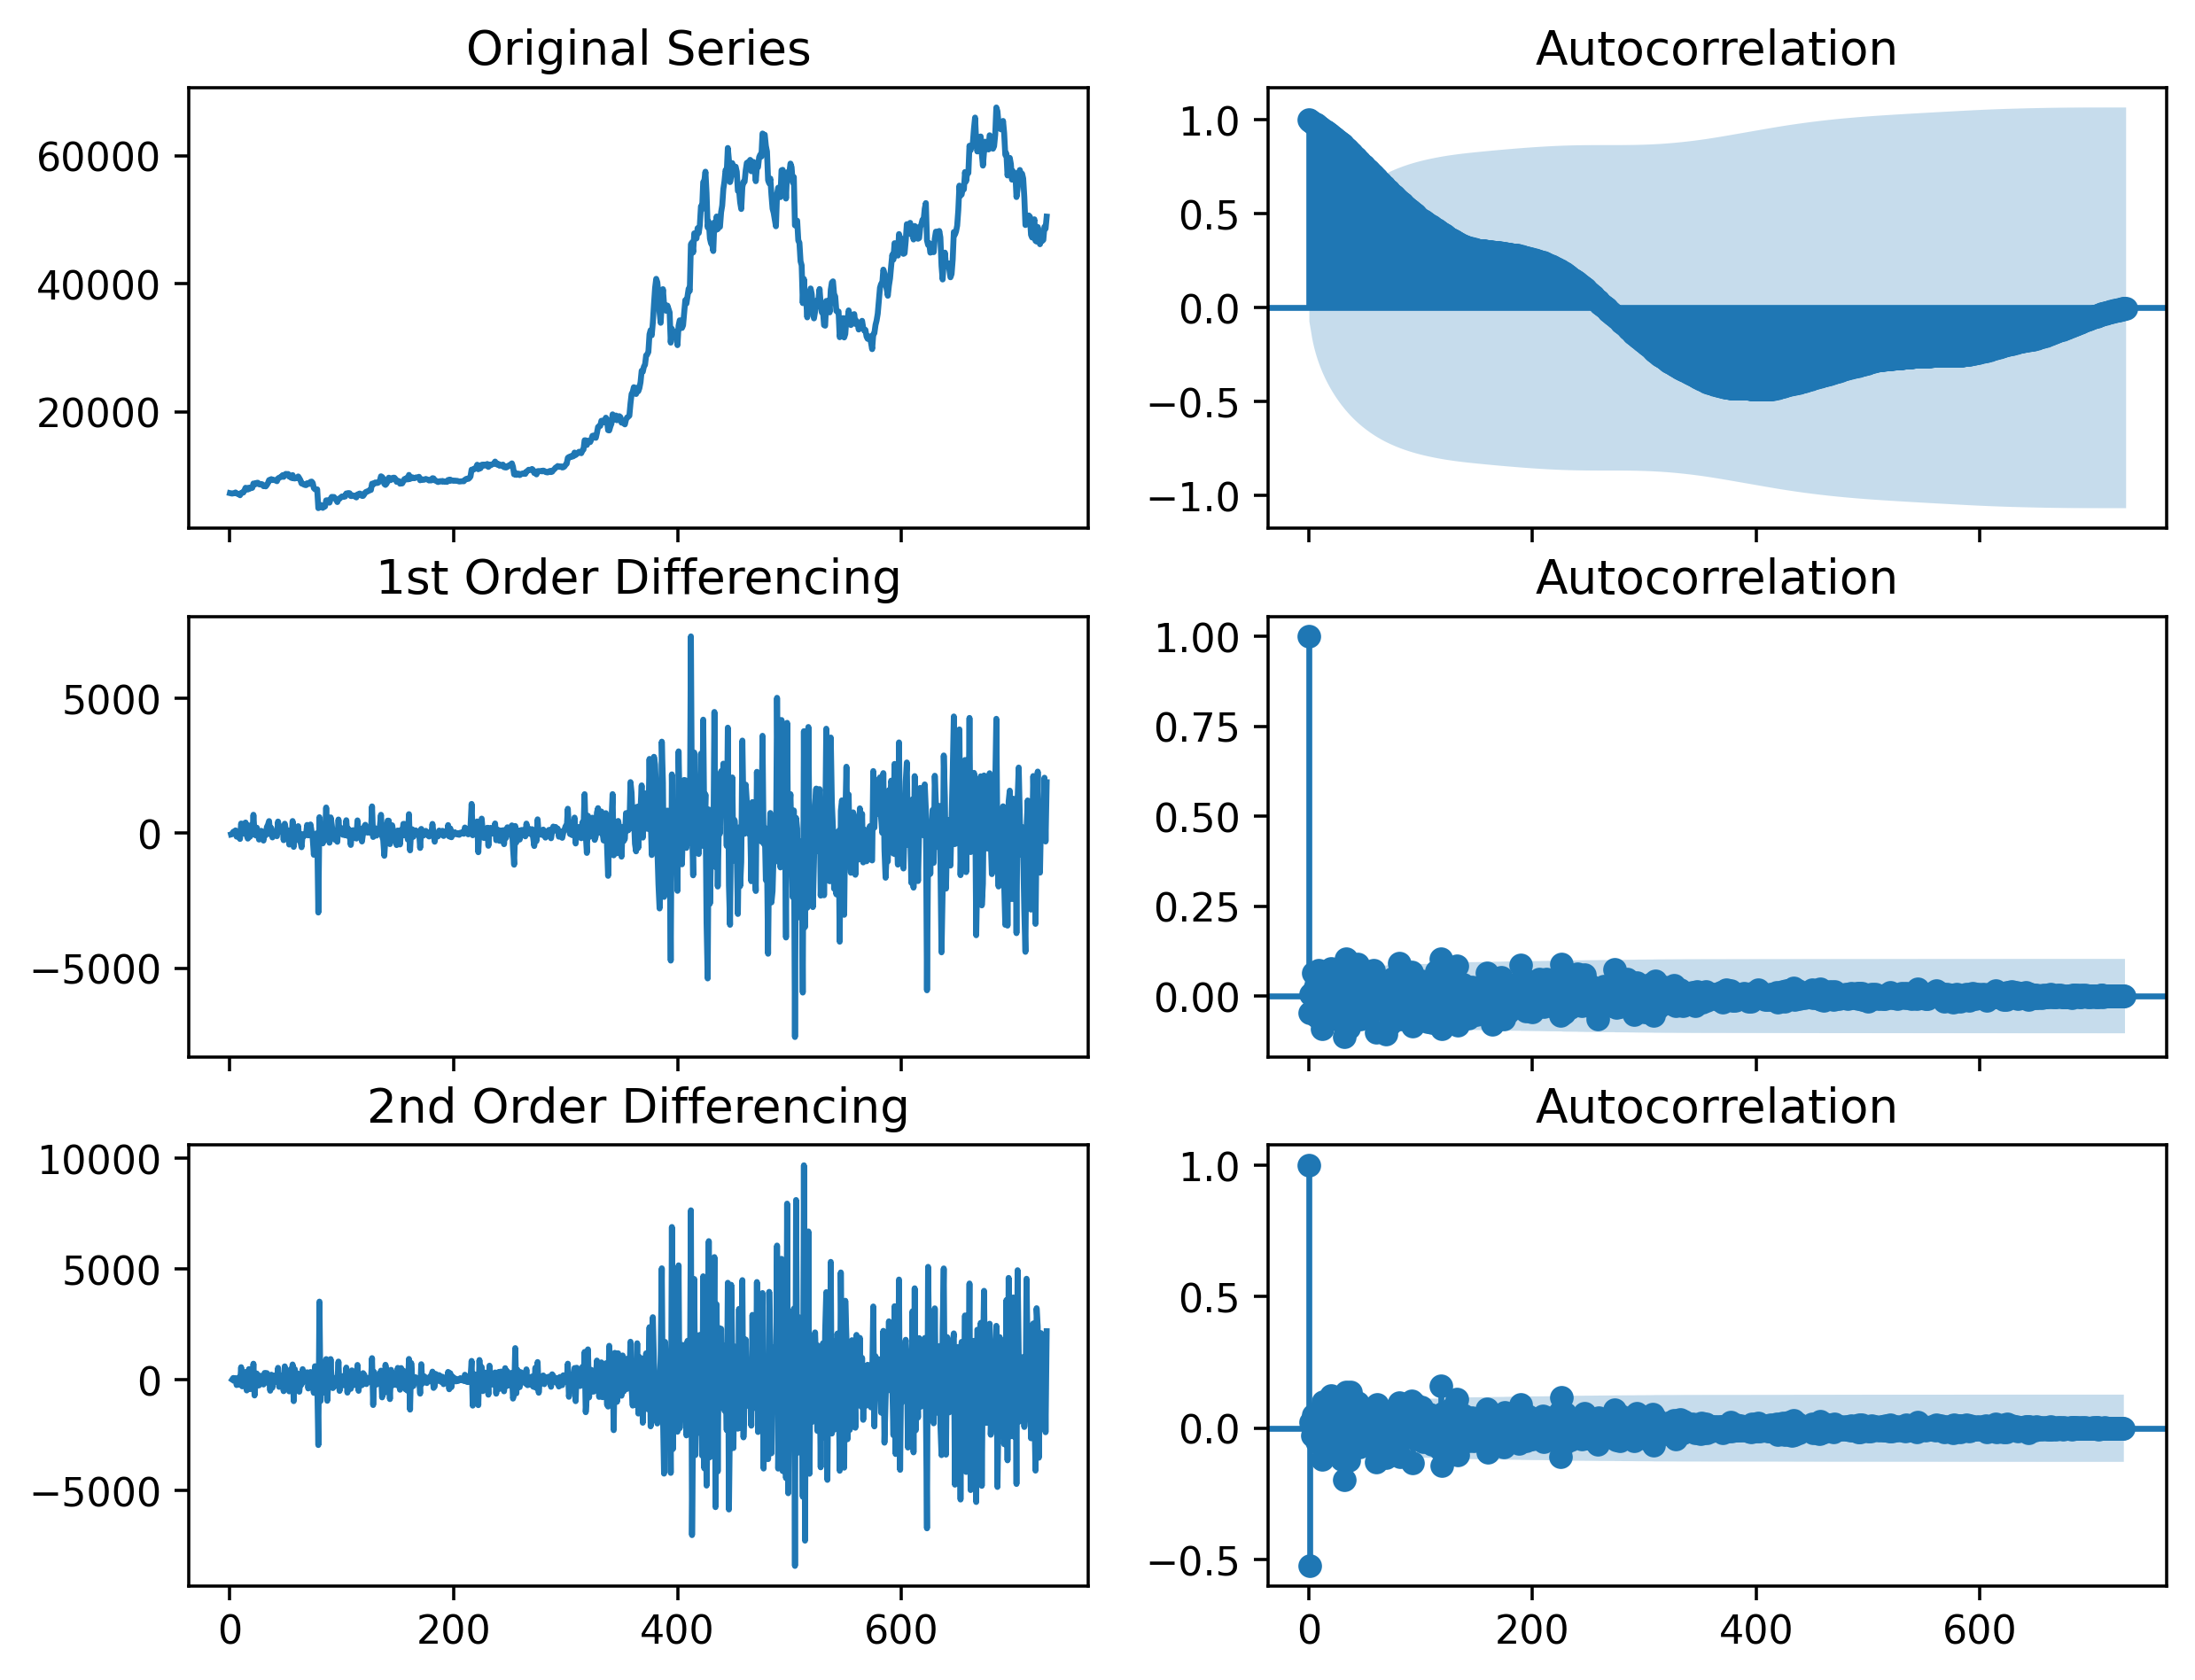

In [88]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':320})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(prices_data_for_arima_df['Close'].values); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(prices_data_for_arima_df['Close'].values, ax=axes[0, 1], lags=len(prices_data_for_arima_df['Close'].values)-1)


# 1st Differencing
axes[1, 0].plot(prices_data_for_arima_df['Close'].diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(prices_data_for_arima_df['Close'].diff().dropna().values, ax=axes[1, 1], lags=len(prices_data_for_arima_df['Close'].values)-2)

# 2nd Differencing
axes[2, 0].plot(prices_data_for_arima_df['Close'].diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(prices_data_for_arima_df['Close'].diff().diff().dropna().values, ax=axes[2, 1], lags=len(prices_data_for_arima_df['Close'].values)-3)

plt.show()

For the above series, the time series reaches stationarity with the first order

In [92]:
from pmdarima.arima.utils import ndiffs

In [96]:
tests = ['adf', 'kpss', 'pp']
for test in tests:
    test_value_int = ndiffs(prices_data_for_arima_df['Close'].values, test=test)
    print(f'{test} value: {test_value_int}')

adf value: 1
kpss value: 1
pp value: 1


## AR term (p)

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


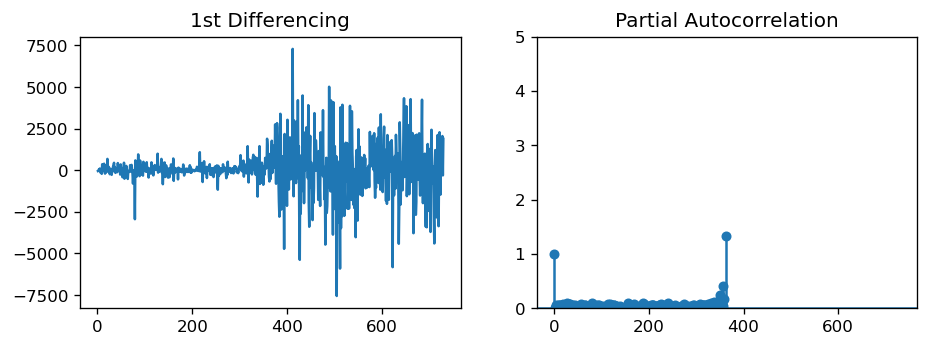

In [112]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(prices_data_for_arima_df['Close'].diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(prices_data_for_arima_df['Close'].diff().dropna().values, ax=axes[1], lags=len(prices_data_for_arima_df['Close'].diff().values)/2-1)

plt.show()

fix the p as 1

## MA term (q)

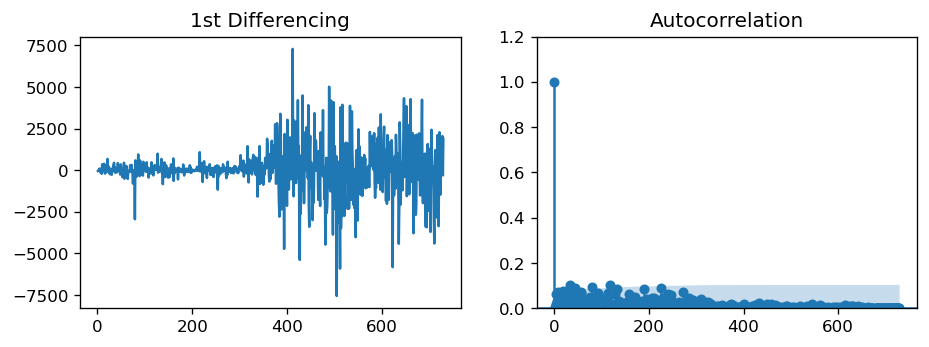

In [118]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(prices_data_for_arima_df['Close'].diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(prices_data_for_arima_df['Close'].diff().dropna().values, ax=axes[1], lags=len(prices_data_for_arima_df['Close'].diff().values)-2)

plt.show()

fix q as 1

## ARIMA Model

In [136]:
from statsmodels.tsa.arima_model import ARIMA

In [242]:
# 1,1,1 ARIMA Model
model = ARIMA(prices_data_for_arima_df['Close'].values, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  730
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6307.477
Method:                       css-mle   S.D. of innovations           1368.452
Date:                Thu, 23 Dec 2021   AIC                          12624.955
Time:                        20:54:21   BIC                          12647.920
Sample:                             1   HQIC                         12633.815
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.1020     54.192      1.109      0.267     -46.112     166.316
ar.L1.D.y      0.8172      0.242      3.370      0.001       0.342       1.292
ma.L1.D.y     -0.8656      0.244     -3.555      0.0

In [259]:
# Forecast
n_periods = 60
fc, stderr, confint = model_fit.forecast(steps=n_periods)
index_of_fc = np.arange(len(prices_data_for_arima_df['Close']), len(prices_data_for_arima_df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(prices_data_for_arima_df['Close'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Bitcoin price")
plt.show()

The P Values of the AR1 and MA1 terms are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

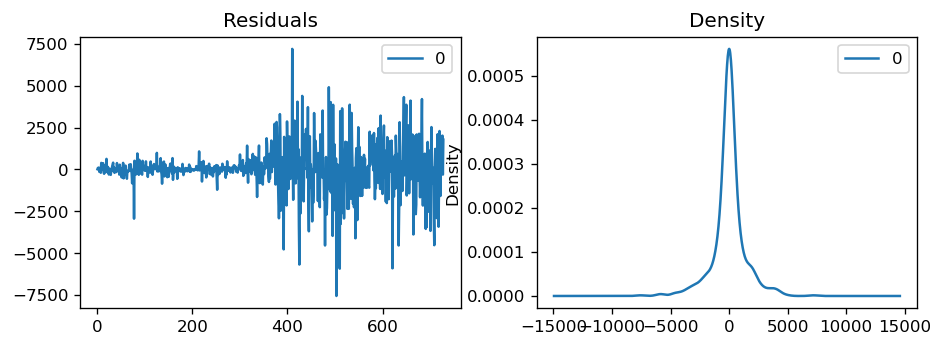

In [192]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

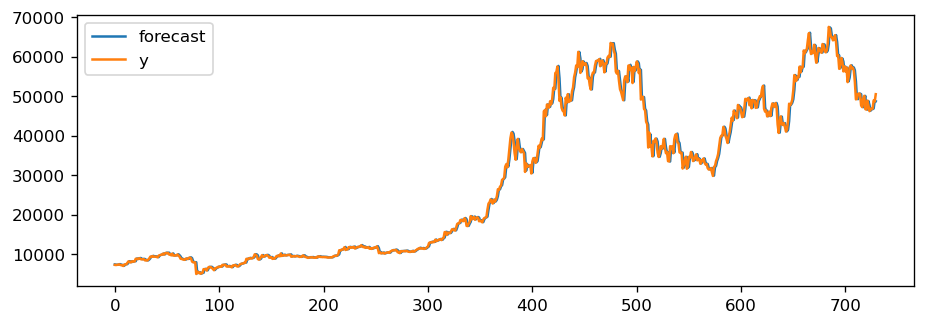

In [150]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [177]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
prices_data_for_arima_whole_size_int = len(prices_data_for_arima_df['Close'].values)
prices_data_for_arima_test_amount_int = int(prices_data_for_arima_whole_size_int*0.85)
train = prices_data_for_arima_df['Close'][:prices_data_for_arima_test_amount_int]
test = prices_data_for_arima_df['Close'][prices_data_for_arima_test_amount_int:]

In [183]:
type()

pandas.core.series.Series

In [230]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=0)  

# Forecast
fc, se, conf = fitted.forecast(prices_data_for_arima_whole_size_int-prices_data_for_arima_test_amount_int, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

In [213]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.11796628805827573,
 'me': -27.583070056295004,
 'mae': 6242.538687572586,
 'mpe': 0.01655480910930039,
 'rmse': 7038.4761385841,
 'acf1': 0.9594595344324597,
 'corr': 0.2482280999784143,
 'minmax': 0.10816776369377734}

# Auto Arima 

In [214]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


In [238]:
model = pm.auto_arima(prices_data_for_arima_df['Close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12624.051, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12621.551, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12622.043, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12622.070, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12620.911, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.127 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6309.455
Date:                Thu, 23 Dec 2021   AIC                          12620.911
Time:                        20:51:16   BIC                          12625.504
Sample:                             0   HQIC                         12622.683
                                - 731                                  

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


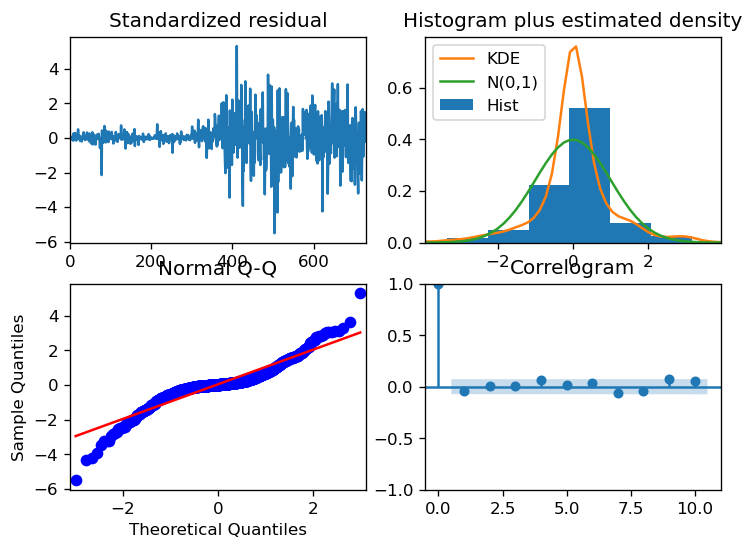

In [239]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

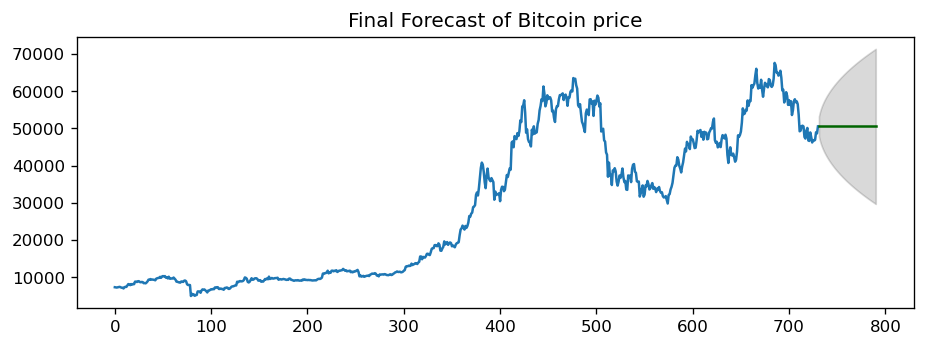

In [240]:
# Forecast
n_periods = 60
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(prices_data_for_arima_df['Close']), len(prices_data_for_arima_df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(prices_data_for_arima_df['Close'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Bitcoin price")
plt.show()